# Generate figures for publication
_[work in progress]_

##  Tactile stimulation examples

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
from neuroprocessing.imagingtrials import ImagingTrialLoader
from skimage import io
from skimage.exposure import rescale_intensity
from skimage.filters import gaussian
from skimage.util import montage

os.makedirs('figs', exist_ok=True)
def plot_STA_img_and_dff(imaging_trial,
                         trial_ROI,
                         show_montage = True,
                         flipLR = True,
                         bleach_subtract = True,
                         tiff_out = None,
                         **dff_plot_kwargs):
    """
    Generate a montage or max projection image of the stimulus-triggered average (STA) of the 
    imaging trial, along with the DF/F trace of the trial.
    """
    mask = imaging_trial.load_mask()
    _, t, dff = imaging_trial.get_sta_stack(1, 5, .5, trial_ROI)
    sta_df, _, _ = imaging_trial.get_sta_stack(1, 5, .5)

    # remove linear trend from dff (remnants of bleaching)
    # only fit first and last 3 elements
    if bleach_subtract:
        dff = dff - np.polyval(np.polyfit(np.array([t[:3], t[-3:]]).flatten(),
                                        np.array([dff[:3], dff[-3:]]).flatten(), 1),
                                        t)

    # avreage over trials
    sta_df = sta_df.mean(axis=0)

    # add xy blur to sta_df image
    sta_df = gaussian(sta_df, sigma=2, channel_axis=0)

    # rescale to (0, 1), ignoring masked out areas
    sta_df = rescale_intensity(sta_df,
                               in_range=(sta_df[sta_df>0].min(), sta_df.max()),
                               out_range=(0, 1),
                               )

    # set everything outside the mask to 0
    sta_df = sta_df * mask

    if flipLR:
        sta_df = np.flip(sta_df, axis=2)

    if show_montage:
        f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
        axs[0].imshow(montage(sta_df,
                        fill = 0,
                        padding_width = 20,
                        rescale_intensity=True,
                        grid_shape= None,
                        ),
                    cmap='inferno',
                    )

    else:
        # max projection over time
        sta_df_max = sta_df.max(axis=0)

        f, axs = plt.subplots(1, 2, figsize=(5, 3))
        axs[0].imshow(sta_df_max, cmap='inferno', aspect='auto')

    if tiff_out is not None:
        io.imsave(tiff_out, (sta_df*255).astype(np.uint8))

    axs[0].axis('off')
    axs[1].plot(t, dff)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('dF/F')
    axs[1].set(**dff_plot_kwargs)

    f.suptitle(imaging_trial)
    plt.tight_layout()


# Define ROIs for the LHL and RHL in the somatosensory cortex (SSC)
# note: this is defined in non-flipped coordinates!

ssc_LHL_roi = {
    "center": (125,175),  # (x, y)
    "width": 80,
    "height": 80
}
ssc_RHL_roi = {
    "center": (265,175),  # (x, y)
    "width": 80,
    "height": 80
}

ssc_LHL_lido_roi = {
    "center": (175,225),  # (x, y)
    "width": 60,
    "height": 60
}

ssc_RFL_roi = {
    "center": (335,210),  # (x, y)
    "width": 50,
    "height": 50
}

### RHL example trial

Initialized with 91 trials.
Filtered to 1 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1/mask_processed_Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1.npy
Frames pre-stim: 5, Frames post-stim: 25
Frames pre-stim: 5, Frames post-stim: 25


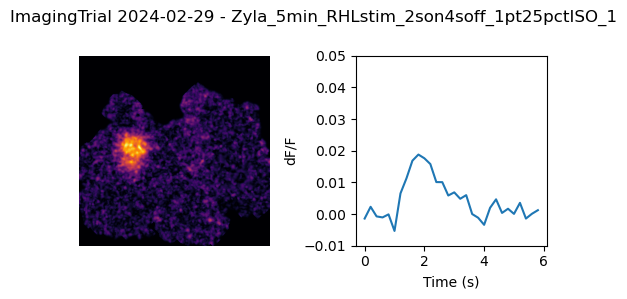

In [4]:
imaging_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
imaging_trials.filter(exp_dir='2024-02-29',# "2024-03-19",
                      limb='RHL',
                      rec_time='5min',
                     )
trial = imaging_trials.trials[0]

plot_STA_img_and_dff(trial,
                     ssc_RHL_roi,
                     show_montage=False,
                     flipLR=True,
                     bleach_subtract=True,
                     tiff_out = 'figs/STA_RHL.tif',
                     ylim=[-0.01, 0.05])


### LHL example trial

Initialized with 91 trials.
Filtered to 1 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_2/mask_processed_Zyla_5min_LHLstim_2son4soff_1pt25pctISO_2.npy
Frames pre-stim: 5, Frames post-stim: 25
Frames pre-stim: 5, Frames post-stim: 25


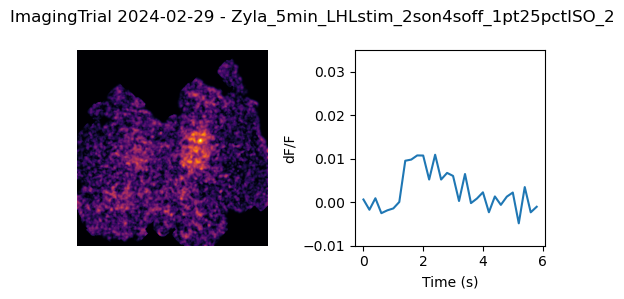

In [5]:
imaging_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
imaging_trials.filter(exp_dir='2024-02-29',
                      limb='LHL',
                      rec_time='5min',
                      remainder='.*pt25pctISO_2'
                     )
trial = imaging_trials.trials[0]

plot_STA_img_and_dff(trial,
                     ssc_LHL_roi,
                     show_montage=False,
                     flipLR=True,
                     bleach_subtract=True,
                     tiff_out = 'figs/STA_LHL.tif',
                     ylim=[-0.01, 0.035]
                     )

### RFL example trial

Initialized with 91 trials.
Filtered to 1 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-21/Zyla_5min_RFLstim_2son4soff_1pt25pctISO_deeper_2/mask_processed_Zyla_5min_RFLstim_2son4soff_1pt25pctISO_deeper_2.npy
Frames pre-stim: 4, Frames post-stim: 24
Frames pre-stim: 4, Frames post-stim: 24


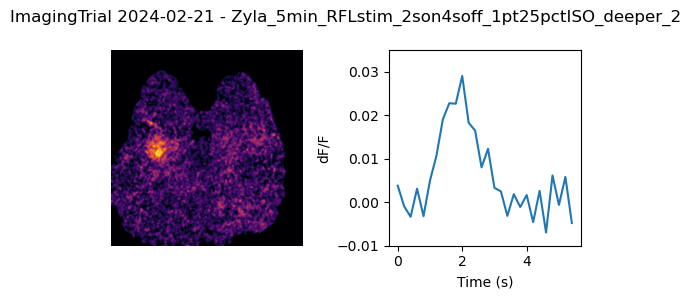

In [6]:
imaging_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
imaging_trials.filter(exp_dir='2024-02-21',
                      limb='RFL',
                      rec_time='5min',
                     )
trial = imaging_trials.trials[0]

plot_STA_img_and_dff(trial,
                     ssc_RFL_roi,
                     show_montage=False,
                     flipLR=True,
                     bleach_subtract=True,
                     tiff_out = 'figs/STA_RFL.tif',
                     ylim=[-0.01, 0.035]
                     )

# Lidocaine results
 * Tactile stimulation before and after localized lidocaine administration with saline as control

Initialized with 91 trials.
Filtered to 4 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_1/mask_processed_Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_1.npy
Frames pre-stim: 4, Frames post-stim: 24
Frames pre-stim: 4, Frames post-stim: 24
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postlidocaine_2/mask_processed_Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postlidocaine_2.npy
Frames pre-stim: 4, Frames post-stim: 24
Frames pre-stim: 4, Frames post-stim: 24
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postsaline_1/mask_processed_Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postsaline_1.npy
Frames pre-stim: 4, Frames post-stim: 24
Frames pre-stim: 4, Frames post-stim: 24


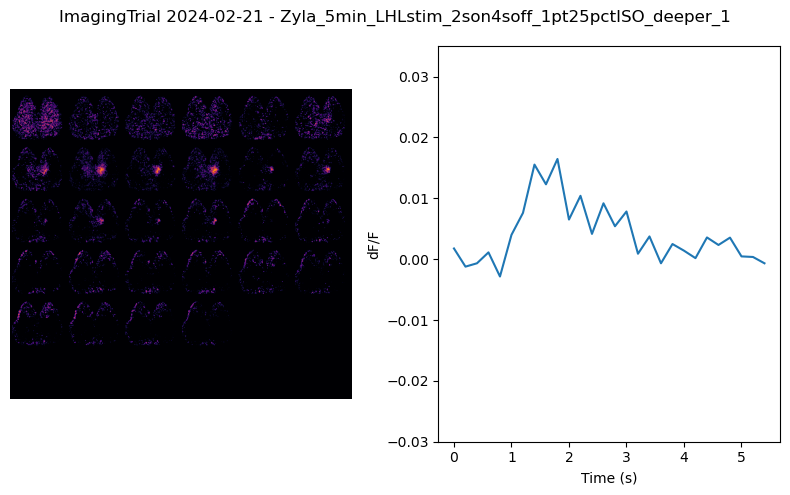

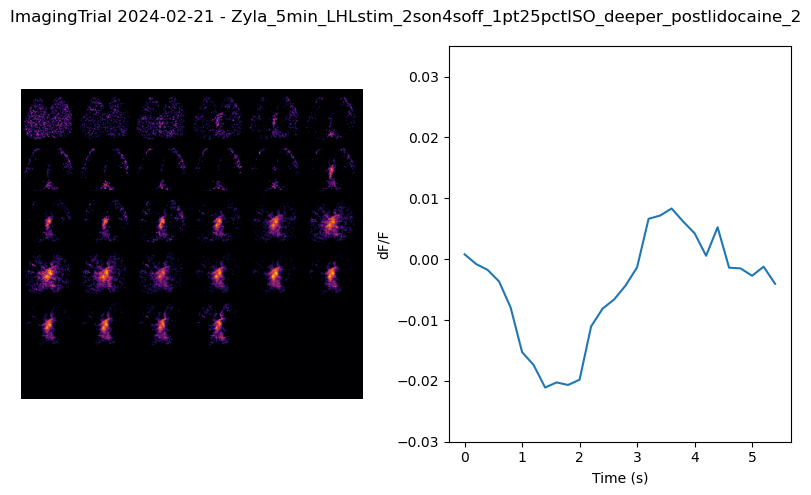

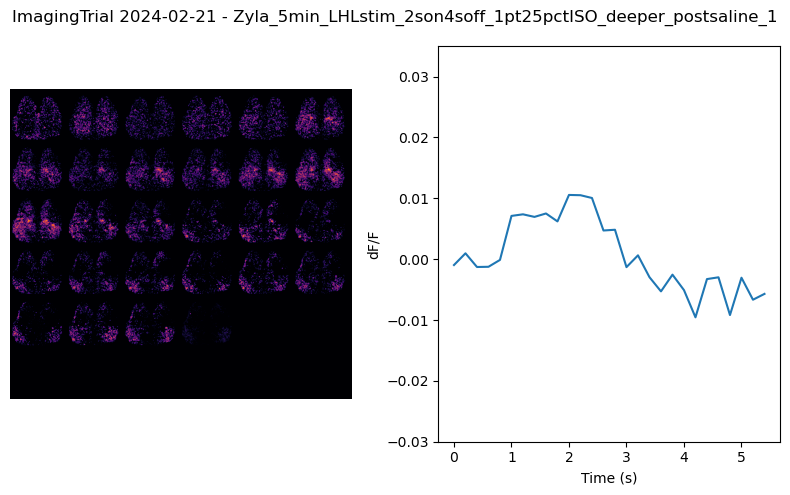

In [7]:
imaging_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
imaging_trials.filter(exp_dir='2024-02-21',
                      limb='LHL',
                      rec_time='5min',
                     )


trial_pre = [t for t in imaging_trials if 'Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_1' in str(t)][0]
trial_post = [t for t in imaging_trials if 'Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postlidocaine_2' in str(t)][0]
trial_sal = [t for t in imaging_trials if 'Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postsaline_1' in str(t)][0]

plot_STA_img_and_dff(trial_pre,
                    ssc_LHL_lido_roi,
                    show_montage=True,
                    bleach_subtract=True,
                    tiff_out = 'figs/lido_initial.tif',
                    ylim=[-0.03, 0.035]
                    )
plot_STA_img_and_dff(trial_post,
                    ssc_LHL_lido_roi,
                    show_montage=True,
                    bleach_subtract=False,
                    tiff_out = 'figs/lido_lido.tif',
                    ylim=[-0.03, 0.035]
                    )
plot_STA_img_and_dff(trial_sal,
                    ssc_LHL_lido_roi,
                    show_montage=True,
                    bleach_subtract=False,
                    tiff_out = 'figs/lido_saline.tif',
                    ylim=[-0.03, 0.035]
                    )


### Breathing rate of lidocaine-related trials

Need to load raw videos from S3FS (make sure it is mounted first)

 * Initial trial is `s3fs://Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_1`
 * Saline trial is `s3fs://Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postsaline_1`
 * Lidocaine trial is `s3fs://Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postlidocaine_2`

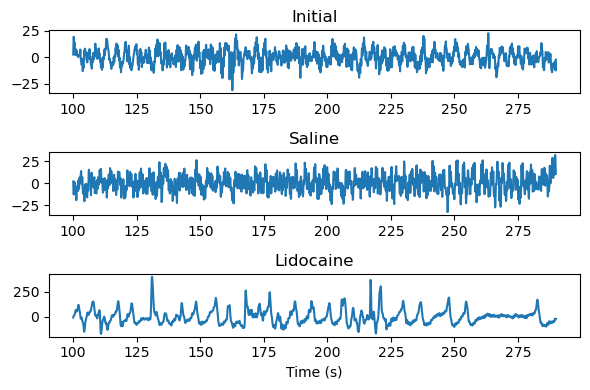

In [8]:
from pathlib import Path

from scipy.signal import butter, filtfilt
from skimage import io

base_dir = '/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens'
trial_paths = {'Initial': Path(base_dir) / 'Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_1',
               'Saline': Path(base_dir) / 'Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postsaline_1',
               'Lidocaine': Path(base_dir) / 'Videos/2024-02-21/Zyla_5min_LHLstim_2son4soff_1pt25pctISO_deeper_postlidocaine_2',
              }

fs = 10
frame_start = 1000
frame_end = 2900
t_vec = np.arange(frame_start, frame_end) / fs
min_breathing_freq, max_breathing_freq = 0.5, 2 # frequency range to look for breathing rate (Hz)

f,axs = plt.subplots(nrows=len(trial_paths), ncols=1, figsize=(6,4))
for t,ax in zip(trial_paths, axs):
    img = io.imread(list(trial_paths[t].glob('*.tif'))[0])
    center = np.array(img.shape) // 2
    roi = img[frame_start:frame_end,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
    roi_mean = np.mean(roi, axis=(1,2))
    # high pass filter signal to remove low frequency drift
    b, a = butter(1, [0.1, 2], 'bandpass', fs = fs)
    signal_hp = filtfilt(b, a, roi_mean)
    ax.plot(t_vec, signal_hp)
    ax.set_title(t)
axs[-1].set_xlabel('Time (s)')
plt.tight_layout()


# Injection analysis
 * Stimulation always happens at t=60 seconds

## Capsaicin trials


In [9]:
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import rescale_intensity
import numpy as np

def plot_montage_and_trace_pairs(imaging_trials,
                                 colors,
                                 montage_grid_shape = None,
                                 trace_roi = None,
                                 trace_ylim = None,
                                 trace_xlim = None,
                                 tiff_out = None,
                                 ):
    """
    Plot montages and traces for a list of ImagingTrials. Optionally save the montage stack as tiff.
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,5),
                            gridspec_kw={'height_ratios': [3, 1],
                                         'width_ratios': [1,1],
                                         'wspace' : .1,
                                         'hspace' : .05,
                                         }
                            )
    montage_stacks = []
    for trial,ax, line_color in zip(imaging_trials, axs.T, colors, strict=True):
        # montage plot
        montage_stack = trial.plot_montage(s_start = 0,
                           s_end = 1200,
                           s_step = 30,
                           montage_grid_shape = montage_grid_shape,
                           ax=ax[0],
                           cmap='inferno',
                           aspect='equal')
        ax[0].axis('off')

        # trace plot
        t, trace = trial.load_trace(roi = trace_roi)
        trace = trace - np.polyval(np.polyfit(t, trace, 1), t)
        trace = trace - trace[np.where(t >= 0)[0][0]]
        ax[1].plot(t, trace, color=line_color)
        ax[1].axvline(x=0, color='k', linestyle='--')
        ax[1].set_xlim(trace_xlim)
        ax[1].set_ylim(trace_ylim)

        montage_stacks.append(montage_stack)
    axs[1,1].set_yticks([])


    if tiff_out is not None:
        # rescale to max and min of montages in montage_stacks
        montage_stacks_np = np.vstack(montage_stacks)
        min_val, max_val = montage_stacks_np.min(), montage_stacks_np.max()
        montage_stacks = [rescale_intensity(m,
                                          in_range=(min_val, max_val),
                                          out_range=(0, 2**8-1),
                                          ) for m in montage_stacks]
        for trial, montage in zip(imaging_trials, montage_stacks, strict=True):
            io.imsave(tiff_out + str(trial) + '.tif', montage.astype(np.uint8))

COLOR_SALINE = '#336699'
COLOR_HIST = '#33CC99'
COLOR_CAPSAICIN = '#FF3333'


### Different limbs trial (2024-03-19)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-19/Zyla_15min_LHL_carrierinj_1pt5pctISO_1_1/mask_processed_Zyla_15min_LHL_carrierinj_1pt5pctISO_1_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-19/Zyla_30min_RHL_40ugin10uL_1pt5pctISO_1_1/mask_processed_Zyla_30min_RHL_40ugin10uL_1pt5pctISO_1_1.npy


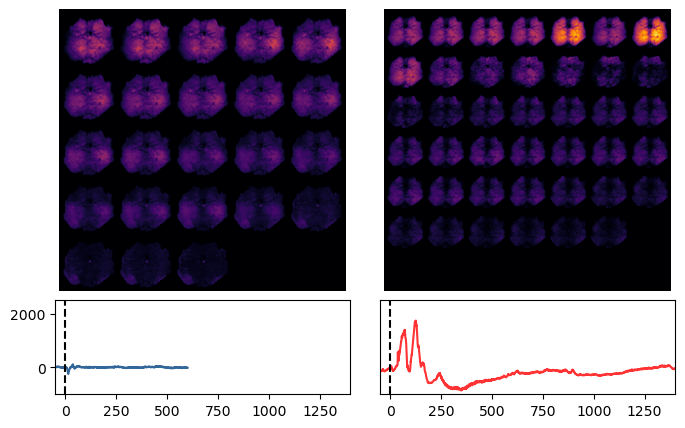

In [10]:
from neuroprocessing.imagingtrials import ImagingTrialLoader

# in this experiment, LHL was injected with vehicle, RHL with capsicin
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-19',
                  limb='(L|R)HL$',
                 )
plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_CAPSAICIN],
                             montage_grid_shape = None,
                             trace_ylim = [-1000,2500],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/diff_limbs_'
                             )


### Same limb trial (2024-03-20)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-18/Zyla_15min_LHL_carrierinj_1pt25pctISO_1/mask_processed_Zyla_15min_LHL_carrierinj_1pt25pctISO_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-18/Zyla_30min_LHL_capsacirinj_1pt25pctISO_1/mask_processed_Zyla_30min_LHL_capsacirinj_1pt25pctISO_1.npy


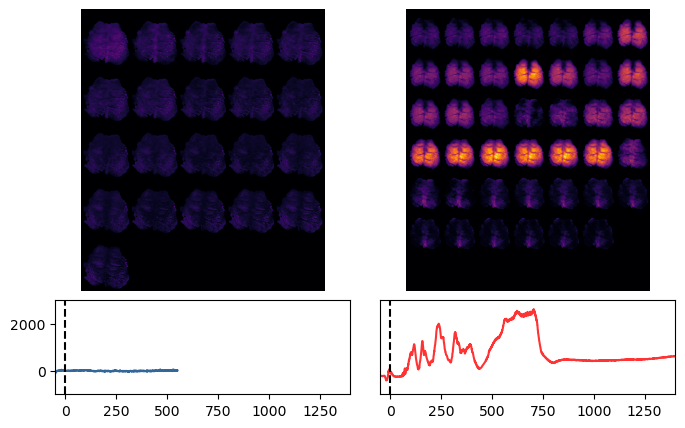

In [11]:
# in this experiment, both injections were done in LHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-18',# "2024-03-19",
                  limb='LHL',
                  injection_type='.*inj'
                 )

plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_CAPSAICIN],
                             montage_grid_shape = None,
                             trace_ylim = [-1000,3000],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/same_limb_'
                             )


### Nape trial

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-18/Zyla_15min_nape_carrierinj_1pt25pctISO_1/mask_processed_Zyla_15min_nape_carrierinj_1pt25pctISO_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-18/Zyla_30min_nape_40ugin10uLcapsacininj_1pt25pctISO_1/mask_processed_Zyla_30min_nape_40ugin10uLcapsacininj_1pt25pctISO_1.npy


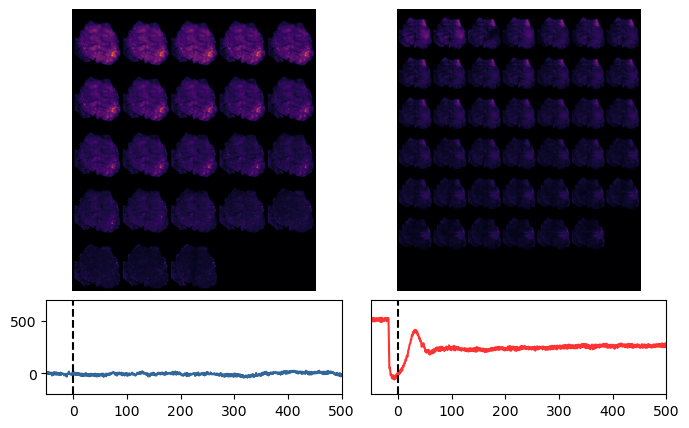

In [12]:
# in this experiment, both injections were done in LHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-18',# "2024-03-19",
                  limb='nape',
                  injection_type='.*inj'
                 )

nape_roi = {
    "center": (288,266),  # (x, y)
    "width": 50,
    "height": 50
}

# reverse order to plot saline first
inj_trials = inj_trials[-1::-1]
plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_CAPSAICIN],
                             montage_grid_shape = None,
                             trace_ylim = [-200,700],
                             trace_xlim = [-50, 500],
                             trace_roi = nape_roi,
                             tiff_out = 'figs/nape_',
                             )


## Histamine trials

### RHL trial (2024-02-29)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_15min_RHL_salineinj_wpushbutton_1/mask_processed_Zyla_15min_RHL_salineinj_wpushbutton_1.npy
Frame start: 0, Frame end: 1496, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_30min_RHL_50uL27MMHistinj_wpushbutton_1/mask_processed_Zyla_30min_RHL_50uL27MMHistinj_wpushbutton_1.npy


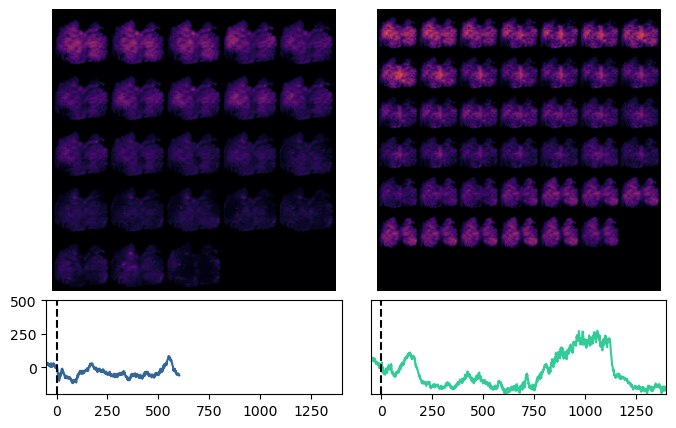

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from neuroprocessing.imagingtrials import ImagingTrialLoader

# in this experiment, both injections were done in RHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-02-29',# "2024-03-19",
                  limb='RHL$',
                  injection_type='.*inj'
                )

plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_HIST],
                             montage_grid_shape = None,
                             trace_ylim = [-200,500],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/hist_rhl20240229_',
                             )

### LHL trial (2024-02-29)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_15min_LHL_salineinj_withpushbutton_1/mask_processed_Zyla_15min_LHL_salineinj_withpushbutton_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_30min_LHL_50uL27MMHistinj_withpushbutton_1/mask_processed_Zyla_30min_LHL_50uL27MMHistinj_withpushbutton_1.npy


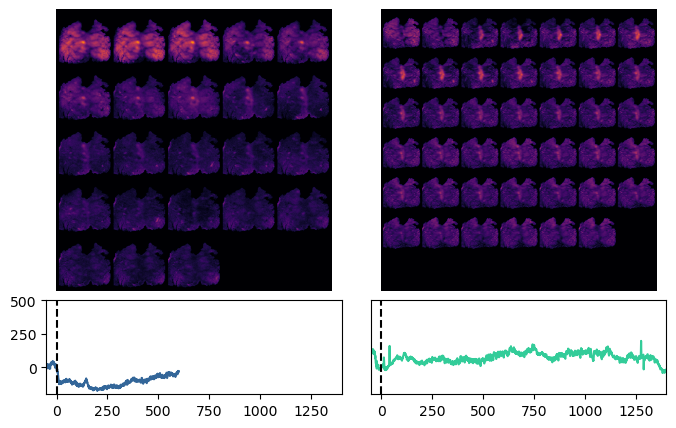

In [14]:
# in this experiment, both injections were done in RHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-02-29',# "2024-03-19",
                  limb='LHL$',
                  injection_type='.*inj'
                )

# reverse order to plot vehicle first
inj_trials = inj_trials[-1::-1]
plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_HIST],
                             montage_grid_shape = None,
                             trace_ylim = [-200,500],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/hist_lhl20240229_',
                             )

### RHL trial (2024-03-06)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_15min_RHL_salineinj_1pt25pctISO_1/mask_processed_Zyla_15min_RHL_salineinj_1pt25pctISO_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_RHL_27mMhistinj_1pt25pctISO_1/mask_processed_Zyla_30min_RHL_27mMhistinj_1pt25pctISO_1.npy


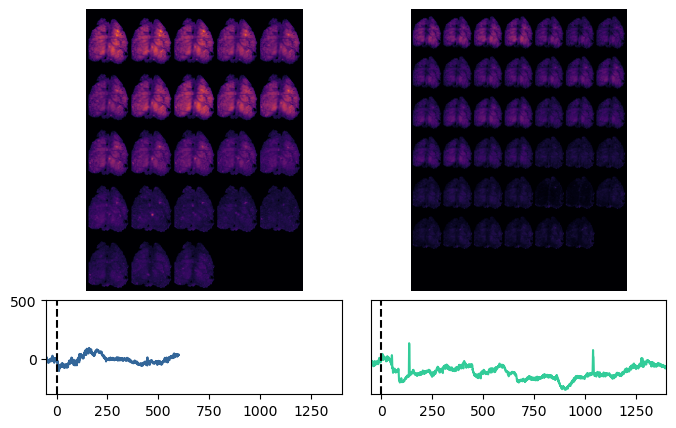

In [15]:
# in this experiment, both injections were done in RHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-06',# "2024-03-19",
                  limb='RHL$',
                  injection_type='.*inj'
                 )

# reverse order to plot vehicle first
inj_trials = inj_trials[-1::-1]
plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_HIST],
                             montage_grid_shape = None,
                             trace_ylim = [-300,500],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/hist_rhl20240306_',
                             )

### LHL trial (2024-03-06)

Initialized with 91 trials.
Filtered to 2 trials.
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_15min_LHL_salineinj_1pt75pctISO_1/mask_processed_Zyla_15min_LHL_salineinj_1pt75pctISO_1.npy
Frame start: 0, Frame end: 1500, Frame step: 37, N frames: 40
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-06/Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1/mask_processed_Zyla_30min_LHL_27mMhistinj_1pt75pctISO_1.npy


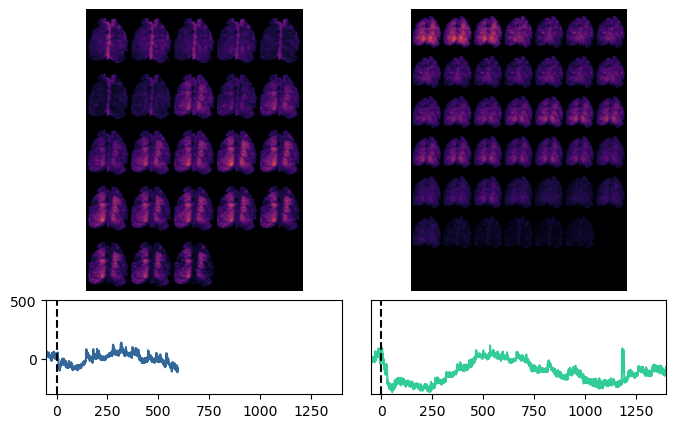

In [16]:
# in this experiment, both injections were done in RHL
inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-06',# "2024-03-19",
                  limb='LHL$',
                  injection_type='.*inj'
                )

plot_montage_and_trace_pairs(inj_trials,
                             [COLOR_SALINE, COLOR_HIST],
                             montage_grid_shape = None,
                             trace_ylim = [-300,500],
                             trace_xlim = [-50, 1400],
                             tiff_out = 'figs/hist_lhl20240306_',
                             )